# 2-D Random Walk
## 1. Theory Investigation
In a plane, consider a sum of N two-dimensional vectors with random orientations. Use phasor notation, and let the phase of each vector be random. Assume N unit steps are taken in an arbitrary direction (i.e., with the angle theta uniformly distributed in [0,2pi) and not on a lattice), as illustrated above. The position z in the complex plane after N steps is then given by:

$$z=\sum_{j=1}^N e^{i \theta_j}$$

which has absolute square:
$$
\begin{aligned}
|z|^2 & =\sum_{j=1}^N e^{i \theta_j} \sum_{k=1}^N e^{-i \theta_k} \\
& =\sum_{j=1}^N \sum_{k=1}^N e^{i\left(\theta_j-\theta_k\right)} \\
& =N+\sum_{\substack{j, k=1 \\
k \neq j}}^N e^{i\left(\theta_j-\theta_k\right)}
\end{aligned}
$$

Each unit step is equally likely to be in any direction ($\theta_j$ and $\theta_k$). The displacements are random variables with identical means of zero, and their difference is also a random variable. Averaging over this distribution, which has equally likely positive and negative values yields an expectation value of 0, so
$$
\left\langle|z|^2\right\rangle=N \\
 |z|_{\mathrm{rms}}=\sqrt{N}
$$

## 2. Simulation on 2-D square lattice 
### 定义需要用的函数

In [143]:
import random
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats

    
def rand_walk_2D(num_steps=1,step_size=1,ifplot=True,out_type=1):
    # ifplot: 是否画出游走轨迹
    # out_type: 1：仅输出最后一个点距离第一个点的距离；2：输出每一步游走的距离
    # 初始化x和y位置
    x_pos = [0]
    y_pos = [0]

    # 模拟随机游走
    for i in range(num_steps):
        # 随机选择方向
        direction = random.choice(['N', 'S', 'E', 'W'])
        
        # 移动位置
        if direction == 'N':
            y_pos.append(y_pos[-1] + step_size)
            x_pos.append(x_pos[-1])
        elif direction == 'S':
            y_pos.append(y_pos[-1] - step_size)
            x_pos.append(x_pos[-1])
        elif direction == 'E':
            x_pos.append(x_pos[-1] + step_size)
            y_pos.append(y_pos[-1])
        else:
            x_pos.append(x_pos[-1] - step_size)
            y_pos.append(y_pos[-1])

    if ifplot:
        # 绘制随机游走的路径
        plt.plot(x_pos, y_pos)
        plt.title('2-D Random Walk')
        plt.scatter(x_pos[0], y_pos[0], color='red', marker='o')
        plt.scatter(x_pos[-1], y_pos[-1], color='blue', marker='o')
        plt.show()
    
    assert out_type in (1,2)
    if out_type==1:
        return sqrt((x_pos[0]-x_pos[-1])**2+(y_pos[0]-y_pos[-1])**2),x_pos,y_pos
    elif out_type==2:
        result = []
        for i in range(len(x_pos)):
            result.append(sqrt((x_pos[0]-x_pos[i])**2+(y_pos[0]-y_pos[i])**2))
        return result,x_pos,y_pos

def linear(x,a,b):
    return a*x+b

def sq_linear(x,a,b):
    return a*np.sqrt(x)+b

def test_fit(function,x_data,y_data,out=False):
    # 使用curve_fit拟合数据
    popt, _ = curve_fit(function, x_data, y_data)
    y_fit = function(x_data,*popt)
    plt.plot(x_data, y_data)
    plt.plot(x_data,y_fit)
    plt.title('2-D Random Walk')
    plt.legend(["y_true","y_fit"])
    plt.show()

    r2res = calc_R_Squared(y_data,y_fit)
    print("y={%.4f}x+{%.4f}"%(popt[0],popt[1]))
    print("R^2= ",r2res)
    if out:
        return popt,r2res
    
def calc_R_Squared(y_data,y_fit):
    # 计算总平方和
    sst = np.sum((y_data - np.mean(y_data))**2)

    # 计算残差平方和
    ssr = np.sum((y_data - y_fit)**2)

    # 计算R平方
    r_squared = 1 - (ssr / sst)
    return r_squared

def explore_distribution(data):
    # 可用的分布函数
    distributions = [        
        stats.beta,
        stats.gamma,
        stats.norm,
        stats.expon,
        stats.lognorm,
        stats.uniform
    ]

    # 拟合分布函数并计算拟合优度指标
    results = []
    for distribution in distributions:
        # 拟合分布函数到数据
        params = distribution.fit(data)

        # 计算Kolmogorov-Smirnov拟合优度指标
        D, p = stats.kstest(data, distribution.cdf, args=params)

        # 记录结果
        results.append((distribution.name, p))

    # 打印结果并选择最好的分布函数
    best_fit_name, best_fit_p = (max(results, key=lambda item: item[1]))
    best_distribution = getattr(stats, best_fit_name)

    # 绘制最佳拟合分布函数和数据的直方图
    #plt.hist(data, bins='auto', density=True)
    plt.hist(data, bins=15, density=True)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Best fit distribution')
    x = np.linspace(min(data), max(data), 100)
    best_fit_params = best_distribution.fit(data)
    print("Best Distribution: ",best_fit_name,sep="")
    plt.plot(x, best_distribution.pdf(x, *best_fit_params), color='r')




### 单次游走
可见这个代码可以正常游走，如下是一段游走轨迹，步长为1，步数为100，最后一个点距离第一个点的距离是8.6

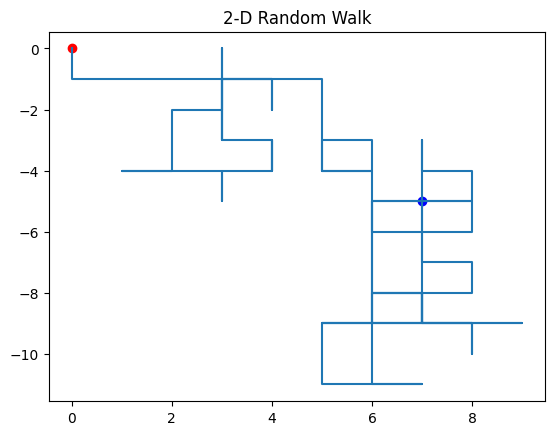

8.602325267042627

In [144]:
[dist_res,x_res,y_res] = rand_walk_2D(num_steps=100)
dist_res

我们进行同步长，同步数的多次游走，统计最后一个点距离初始点的距离,看起来符合某种分布

In [145]:
round_num = 100000
num_steps=100
step_size=1
dist_res_lis = []

for _ in range(round_num):
    [dist_res,_,_] = rand_walk_2D(num_steps,step_size,out_type=1,ifplot=False)
    dist_add = dist_res_lis.append(dist_res)


Best Distribution: beta


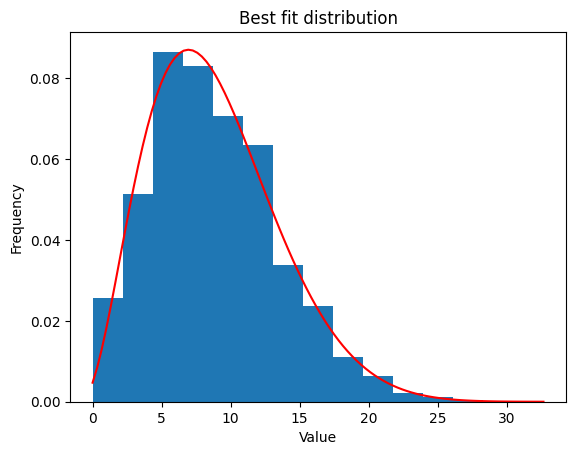

In [146]:
# 探索常见分布对其的拟合
explore_distribution(dist_res_lis)

得到的最佳拟合的分布函数是beta分布


函数形式：
$$
\begin{aligned}
f(x ; \alpha, \beta) & =\frac{x^{\alpha-1}(1-x)^{\beta-1}}{\int_0^1 u^{\alpha-1}(1-u)^{\beta-1} d u} \\
& =\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha) \Gamma(\beta)} x^{\alpha-1}(1-x)^{\beta-1} \\
& =\frac{1}{\mathrm{~B}(\alpha, \beta)} x^{\alpha-1}(1-x)^{\beta-1}
\end{aligned}
$$

如果观察首位距离随着游走时间增加的变化呢？
看起来没有什么规律,忽上忽下

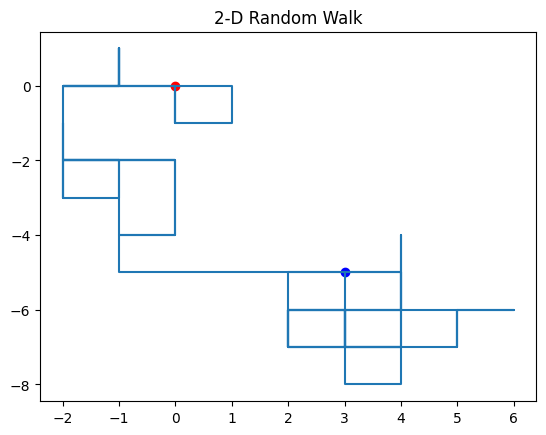

In [147]:
[dist_res,x_res,y_res] = rand_walk_2D(num_steps=100,out_type=2)

Text(0, 0.5, 'distance end to end')

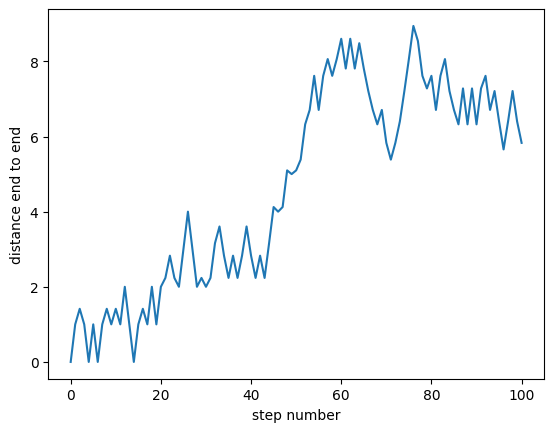

In [148]:
plt.plot(list(range(len(dist_res))),dist_res)
plt.xlabel("step number")
plt.ylabel("distance end to end")

## 多次游走
如果我们在同一步长和步数的条件下做多次游走，把每次轨迹的end to end 距离trajectory数据平均起来呢？
我们可以发现，正如之前推导的，函数逐渐收敛至：
$$|z|_{\mathrm{rms}}=A\sqrt{N}+B$$

Text(0.5, 1.0, 'Mean Distance Evolution')

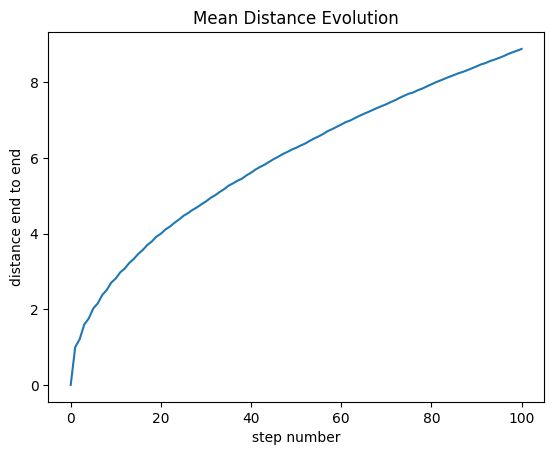

In [149]:
round_num = 10000
num_steps=100
step_size=1
dist_add = np.zeros(num_steps+1)

for _ in range(round_num):
    [dist_res,_,_] = rand_walk_2D(num_steps,step_size,out_type=2,ifplot=False)
    dist_add = dist_add + np.array(dist_res)

dist_avg = dist_add/round_num

x_data = list(range(num_steps+1))
y_data = dist_avg
plt.plot(x_data,y_data)
plt.xlabel("step number")
plt.ylabel("distance end to end")
plt.title("Mean Distance Evolution")

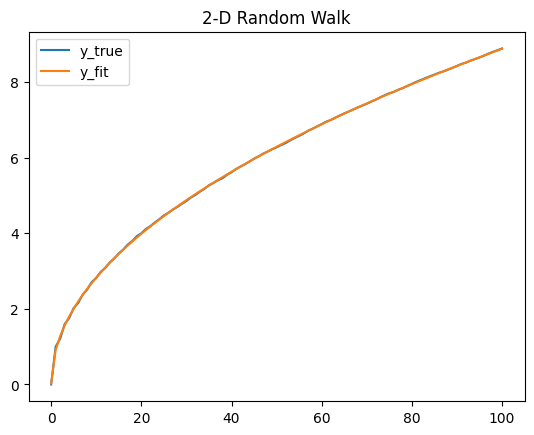

y={0.8852}x+{0.0270}
R^2=  0.9999340435966629


In [150]:
# Fit $D=A*sqrt(N)+B$
test_fit(sq_linear,x_data,y_data)

## 3. References
[1] Weisstein, Eric W. "Random Walk--2-Dimensional." From MathWorld--A Wolfram Web Resource. https://mathworld.wolfram.com/RandomWalk2-Dimensional.html


[2] https://zh.wikipedia.org/zh-cn/%CE%92%E5%88%86%E5%B8%83